In [1]:
import sys
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import pickle as pk
import numpy as np

In [3]:
device = torch.cuda.set_device(0)

In [5]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"

In [6]:
sys.path.append(BASE_DIR)

In [7]:
#embedding_analysis_best_model = "Bindingdb_SimpleCosine_Morgan_ESM_DSCRIPT_cat_rep0_best_model.sav"
prose_no_batch = torch.load(f"{MODEL_BASE_DIR}/davis_basic_cosine_morgan_prose_best_model.sav").eval().cuda()
prose_batch_norm = torch.load(f"{MODEL_BASE_DIR}/davis_basicbatchnorm_cosine_morgan_prose_best_model.sav").eval().cuda()

In [8]:
prose_no_batch

SimpleCosine(
  (mol_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (prot_projector): Sequential(
    (0): Linear(in_features=6165, out_features=1024, bias=True)
    (1): ReLU()
  )
  (activator): Cosine()
)

In [9]:
prose_batch_norm

CosineBatchNorm(
  (mol_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (prot_projector): Sequential(
    (0): Linear(in_features=6165, out_features=1024, bias=True)
    (1): ReLU()
  )
  (mol_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prot_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activator): Cosine()
)

In [10]:
df = pd.read_csv(f"{BASE_DIR}/dataset/DAVIS/test.csv",index_col=0,header=0)

In [11]:
from prot_feats import Prose_f
from mol_feats import Morgan_f

In [12]:
prot_f = Prose_f()
mol_f = Morgan_f()

In [13]:
prot_f.precompute(df['Target Sequence'],to_disk_path='davis',from_disk=True)
mol_f.precompute(df['SMILES'],to_disk_path='davis',from_disk=True)

  0%|                                                                                                | 0/6011 [00:00<?, ?it/s]

--- precomputing Prose protein featurizer ---


  0%|                                                                                                | 0/6011 [00:00<?, ?it/s]

--- saving protein embeddings to davis_Prose_f_PROTEINS.pk ---
--- precomputing morgan molecule featurizer ---


100%|███████████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:03<00:00, 1676.47it/s]


--- saving morgans to davis_Morgan_MOLECULES.pk ---


In [14]:
p_basic = []
p_batchnorm = []
for _, (sm, seq, lab, _, _) in tqdm(df.iterrows(),total=len(df)):
    p_basic.append(prose_no_batch(mol_f(sm).unsqueeze(0), prot_f(seq).unsqueeze(0)).detach().cpu().numpy())
    p_batchnorm.append(prose_batch_norm(mol_f(sm).unsqueeze(0), prot_f(seq).unsqueeze(0)).detach().cpu().numpy())

  0%|          | 0/6011 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
print(f"Prose, Basic: {average_precision_score(df['Label'], p_basic)}")
print(f"Prose, Batch Norm: {average_precision_score(df['Label'], p_batchnorm)}")

Prose, Basic: 0.44979648901620334
Prose, Batch Norm: 0.41565332357448764


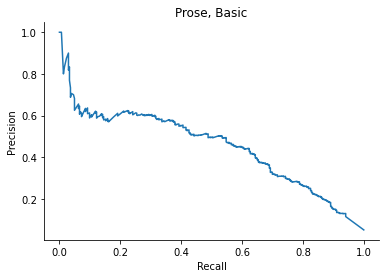

In [17]:
pr, rec, thr = precision_recall_curve(df['Label'], p_basic)
plt.plot(rec, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Prose, Basic')
sns.despine()
plt.show()

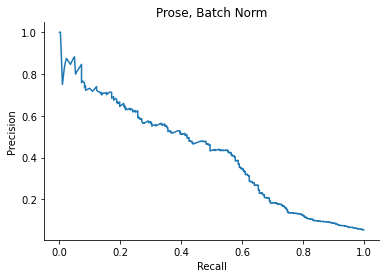

In [18]:
pr, rec, thr = precision_recall_curve(df['Label'], p_batchnorm)
plt.plot(rec, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Prose, Batch Norm')
sns.despine()
plt.show()

In [19]:
molecules = df['SMILES'].unique()
sequences = df['Target Sequence'].unique()

In [20]:
# model = prose_batch_norm
model = prose_no_batch

In [21]:
mol_embeddings = []
prot_embeddings = []

with torch.no_grad():
    for m in tqdm(molecules):
        mol_embeddings.append(model.mol_projector(mol_f(m)))
    for p in tqdm(sequences):
        prot_embeddings.append(model.prot_projector(prot_f(p)))
        
all_embeddings = torch.cat([torch.stack(mol_embeddings,0),torch.stack(prot_embeddings,0)],0).detach().cpu().numpy()
pk.dump(all_embeddings,open('embedding_analysis/prose_batchnorm_davis_embeddings.pk','wb'))

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'embedding_analysis/prose_batchnorm_davis_embeddings.pk'

In [ ]:
all_embeddings = pk.load(open('embedding_analysis/prose_batchnorm_davis_embeddings.pk','rb'))

In [ ]:
import umap
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
distance_matrix = pairwise_distances(all_embeddings, all_embeddings, metric='cosine', n_jobs=-1)

In [ ]:
# emb_points = UMAP(random_state=42,metric='cosine').fit_transform(all_embeddings)
# emb_points = PCA(n_components=2).fit_transform(all_embeddings)
emb_points = TSNE(metric="precomputed").fit_transform(distance_matrix)

In [ ]:
pos_df = df[df['Label'] == 1]

In [ ]:
pos_df.head()

In [ ]:
edge_list = []
for i, m in tqdm(enumerate(molecules),total=len(molecules)):
    for p in pos_df[pos_df['SMILES'] == m]['Target Sequence'].unique():
        edge_list.append(tuple([i, list(sequences).index(p)+len(molecules)]))
# for i, p in tqdm(enumerate(sequences),total=len(sequences)):
#     for m in test_df[test_df['Target Sequence'] == p]['SMILES'].unique():
#         edge_list.append(tuple([list(molecules).index(m),i+len(molecules)]))

In [ ]:
arrow_locs = np.array([(*emb_points[midx], *(emb_points[pidx] - emb_points[midx])) for (midx, pidx) in edge_list])
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(list(emb_points[:,0]),list(emb_points[:,1]),c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ],s=[2 if i < len(molecules) else 6 for i in range(all_embeddings.shape[0]) ])
plt.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],angles='xy', scale_units='xy', scale=1,width=0.00025)
sns.despine()
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Red: molecules, blue: proteins')
# plt.savefig('embedding_analysis/esm_dscript_cat_bindingdb_tsne.png',bbox_inches='tight')
plt.show()

---

In [ ]:
tsne_3d = TSNE(n_components=3, random_state=0, metric="precomputed")
projections = tsne_3d.fit_transform(distance_matrix)

In [ ]:
%matplotlib inline
arrow_locs = np.array([(*projections[midx], *(projections[pidx] - projections[midx])) for (midx, pidx) in edge_list])
sns.set(style = "whitegrid")
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = projections[:,0]
y = projections[:,1]
z = projections[:,2]

ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")

ax.scatter(x, y, z, c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ])
# ax.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],arrow_locs[:,4],arrow_locs[:,5],angles='xyz', scale_units='xyz', scale=1,width=0.00025)

plt.show()

---

In [ ]:
umap_points = UMAP(metric='precomputed').fit_transform(distance_matrix)

In [ ]:
arrow_locs = np.array([(*umap_points[midx], *(umap_points[pidx] - umap_points[midx])) for (midx, pidx) in edge_list])
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(list(umap_points[:,0]),list(umap_points[:,1]),c=['r' if i < len(molecules) else 'b' for i in range(all_embeddings.shape[0]) ],s=[2 if i < len(molecules) else 6 for i in range(all_embeddings.shape[0]) ])
plt.quiver(arrow_locs[:,0],arrow_locs[:,1],arrow_locs[:,2],arrow_locs[:,3],angles='xy', scale_units='xy', scale=1,width=0.00025)
sns.despine()
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Red: molecules, blue: proteins')
# plt.savefig('embedding_analysis/esm_dscript_cat_bindingdb_umap.png',bbox_inches='tight')
plt.show()